In [2]:
# !pip uninstall torch -y
# !pip install torch==1.13.0 torchvision==0.14.0 torchaudio==0.13.0
%env PYTORCH_ENABLE_MPS_FALLBACK=1
import torch
torch.__version__

env: PYTORCH_ENABLE_MPS_FALLBACK=1


'2.3.0.dev20240313'

In [3]:
import pandas as pd
from ast import literal_eval
import numpy as np
from pickle import dump

In [4]:
import matplotlib.pyplot as plt

In [5]:
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from copy import deepcopy

# Train test

In [6]:
# from sklearn.model_selection import train_test_split
# df = pd.read_csv("data/gwm_dataset_3100.csv", sep="\t")
# train, test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
# train.to_csv("data/train_gwm_dataset_3100.csv", sep="\t", index=False)
# test.to_csv("data/test_gwm_dataset_3100.csv", sep="\t", index=False)

# Vizualisation

In [7]:
df = pd.read_csv("data/test_gwm_dataset_3100.csv", sep="\t" , converters={"S": literal_eval, 'P_imp': literal_eval, 'S0': literal_eval})

In [8]:
df.columns

Index(['groups', 'Pb_dict', 'Pb_file', 'q', 'S', 'dt', 'P', 'P_imp', 'S0',
       'nb_newton'],
      dtype='object')

In [9]:
ext = 4
res_length = (2 * ext + 1)

In [10]:
well_loc = np.argmax(np.array(df['S'].values[2]).reshape(res_length, res_length).T)
well_loc

40

In [158]:
i=0

0.6101861987400955 0.4657575783191329


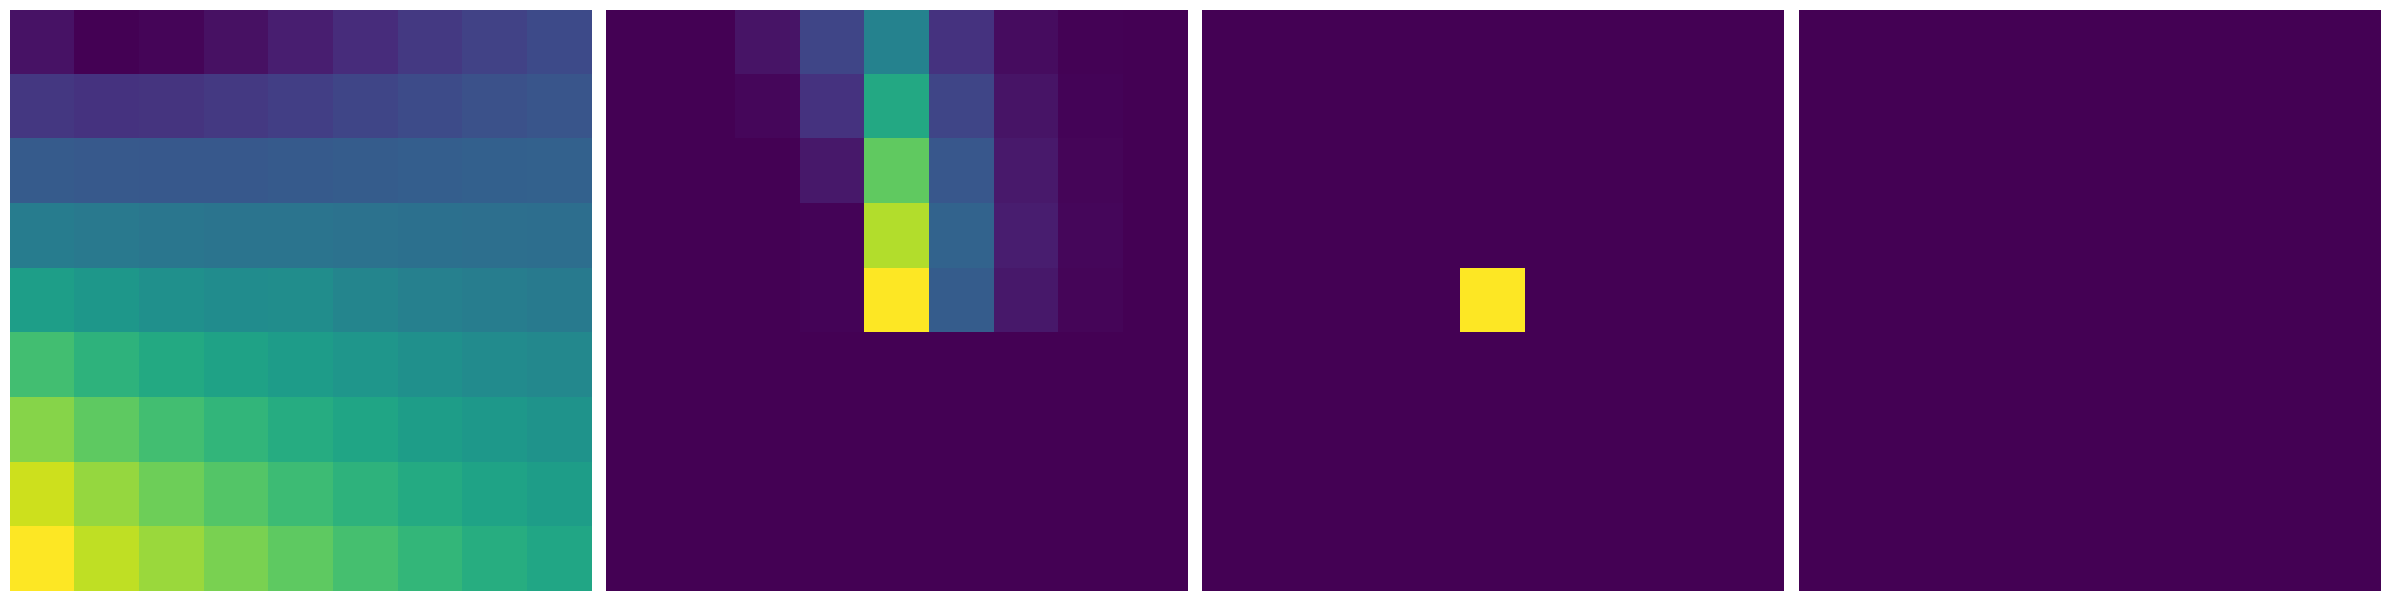

In [159]:
q_flat_zeros = np.zeros(res_length**2)
q_flat_zeros[well_loc] = -df['q'][i]

dt = np.full((res_length, res_length), df['dt'][i])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 24))

ax1.imshow(np.array(df['P_imp'].values[i]).reshape(res_length, res_length).T)
fig.axes[0].invert_yaxis()

ax2.imshow(np.array(df['S'].values[i]).reshape(res_length, res_length).T)
fig.axes[1].invert_yaxis()

ax3.imshow(q_flat_zeros.reshape(res_length, res_length).T)
fig.axes[2].invert_yaxis()

ax4.imshow(dt.reshape(res_length, res_length).T)
fig.axes[3].invert_yaxis()


ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

print(np.max(df['S'][i]), max(df['S0'][i]))
plt.tight_layout()
plt.show()
i+=1

# Model set up

In [160]:
torch.manual_seed(42)
np.random.seed(42)

In [161]:
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

In [162]:
class MyDataset(Dataset):
    def __init__(self, file_name, q_normalizer = None, dt_normalizer = None, P_imp_normalizer = None):
        df = pd.read_csv(file_name, sep="\t", converters={"S": literal_eval, 'P_imp': literal_eval, 'S0': literal_eval})
        df['log_q'] =  -np.log10(-df['q'])
        df['log_dt'] =  np.log(df['dt'])

        # create features maps
        # q is map of 0 everywhere except at well loc
        q_flat_zeros = [np.zeros((res_length*res_length)) for _ in range(len(df['log_q']))]
        for i in range(len(q_flat_zeros)):
          q_flat_zeros[i][well_loc] = df['log_q'][i]

        S0_flat_zeros = [np.full((res_length*res_length), S0) for S0 in df['S0'].values]

        q = torch.from_numpy(np.array([np.reshape(q_f, (res_length, res_length, 1)) for q_f in q_flat_zeros]))
        dt = torch.from_numpy(np.array([np.full((res_length, res_length, 1), qs) for qs in df['log_dt']]))
        S0 = torch.from_numpy(np.array([np.array(v).reshape(res_length, res_length, 1) for v in df['S0'].values]))
        P_imp = torch.from_numpy(np.array([np.array(np.log10(v)).reshape(res_length, res_length, 1) for v in df['P_imp'].values]))

        if not q_normalizer:
          q_normalizer = UnitGaussianNormalizer(q)
        if not dt_normalizer:
          dt_normalizer = UnitGaussianNormalizer(dt)
        if not P_imp_normalizer:
          P_imp_normalizer = UnitGaussianNormalizer(P_imp)

        q = q_normalizer.encode(q)
        dt = dt_normalizer.encode(dt)
        P_imp = P_imp_normalizer.encode(P_imp)

        # concat all features maps to (Nsample, 9, 9, 4)
        x = torch.cat([q, dt, S0, P_imp], 3)


        y = df['S']
        y = torch.from_numpy(np.array([np.array(v).reshape(res_length, res_length, 1) for v in y.values]))

        self.x_train=x.float()
        self.y_train=y.float()
        self.dt_normalizer = dt_normalizer
        self.q_normalizer = q_normalizer
        self.P_imp_normalizer = P_imp_normalizer
        del df

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]

    def normalizers(self):
      return self.q_normalizer, self.dt_normalizer, self.P_imp_normalizer

In [163]:
trainData = MyDataset("data/train_gwm_dataset_3100.csv")
q_normalizer, dt_normalizer, P_imp_normalizer = trainData.normalizers()
testData = MyDataset("data/test_gwm_dataset_3100.csv",
                     q_normalizer=q_normalizer, dt_normalizer=dt_normalizer, P_imp_normalizer=P_imp_normalizer)

In [164]:
print(len(trainData), len(testData))

89280 22320


In [165]:
import matplotlib.pyplot as plt
import random as rd

In [166]:
i=0

In [167]:
BATCH_SIZE=1024

In [168]:
train_dataloader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(testData, batch_size=BATCH_SIZE, shuffle=False)

In [169]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

In [170]:
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width, n_features):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.n_features = n_features
        self.padding = 13 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(n_features, self.width)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

In [171]:
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

In [177]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = 'cpu'

In [178]:
model = FNO2d(modes1 = 12, modes2 = 12, width = 64, n_features=4)
model = model.to(device)

criterion = LpLoss(size_average=False)

lr, momentum = 5e-4 , 0.9

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)

In [179]:
# checkpoint = torch.load( path + "/checkpoints/checkpoint_last_model_global_2d_S_var_v2_FNO_7300.pt")
# model.load_state_dict(checkpoint['model'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# epoch = checkpoint['epoch']

# model.load_state_dict(torch.load(path + "/checkpoints/last_model_global_2d_S_var_FNO_900.pt",  map_location=torch.device(device)))
# loss_dict = load(open(path + '/checkpoints/loss_dict_7300.pkl', 'rb'))
loss_dict = {'train_loss': [], 'val_loss': []}
print(len(loss_dict['val_loss']), len(loss_dict['val_loss']))

0 0


In [180]:
epoch_number = len(loss_dict['val_loss'])
EPOCHS = 10

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train()
    train_loss = 0.

    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs, labels  = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step()
        train_loss += loss.item()
    train_loss /=  (i+1)

    model.eval()

    test_loss = 0.0

    with torch.no_grad():
      for i, vdata in enumerate(test_dataloader):
          vinputs, vlabels = vdata
          vinputs, vlabels = vinputs.to(device), vlabels.to(device)
          voutputs = model(vinputs)
          vloss = criterion(voutputs, vlabels)
          test_loss += vloss.item()

    test_loss /= (i + 1)
    print(f'LOSS train {train_loss:.6f} valid {test_loss:.6f}')
    loss_dict['train_loss'].append(train_loss)
    loss_dict['val_loss'].append(test_loss)
    # keep best model
    if min(loss_dict['val_loss']) == test_loss:
      print(f"New best model at epoch {epoch_number + 1} with test loss {min(loss_dict['val_loss'])}")
      best_model = deepcopy(model)
    epoch_number += 1

EPOCH 1:


KeyboardInterrupt: 

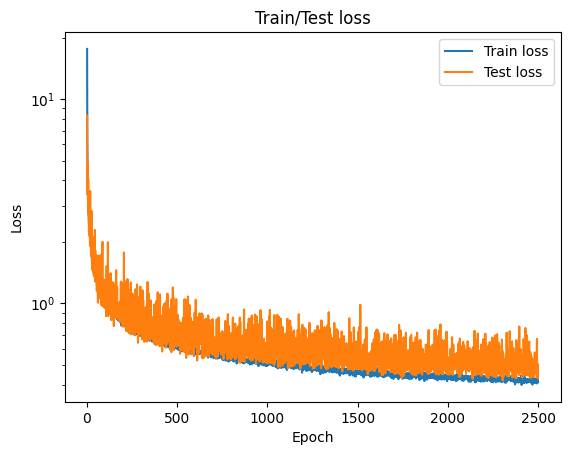

In [94]:
x = list(range(1, len(loss_dict['train_loss'])+1))
fig = plt.plot(figsize=(16,16))
plt.plot(x, loss_dict['train_loss'], label='Train loss')
plt.plot(x, loss_dict['val_loss'], label='Test loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Test loss')
plt.legend()
plt.show()

In [95]:
min_loss = np.argmin(loss_dict['val_loss'])
print(loss_dict['val_loss'][min_loss], loss_dict['train_loss'][min_loss])

0.4187611937522888 0.4254493705884239


In [96]:
checkpoint = {
    'epoch': epoch,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    }

torch.save(checkpoint, f"/checkpoints/GWM_3100_checkpoint_{epoch_number}.pt")

In [97]:
torch.save(best_model.state_dict(), f"/checkpoints/checkpoint_best_model_GWM_local_2d_{epoch_number}.pt")

q_normalizer, dt_normalizer, P_imp_normalizer = trainData.normalizers()
dump(dt_normalizer, open(f"/checkpoints/GWM_dt_normalizer.pkl", 'wb'))
dump(q_normalizer, open(f"/checkpoints/GWM_q_normalizer.pkl", 'wb'))
dump(P_imp_normalizer, open(f"/checkpoints/GWM_P_imp_normalizer.pkl", 'wb'))
dump(loss_dict, open(f"/checkpoints/GWM_loss_dict_{epoch_number}.pkl", 'wb'))